In [1]:
import igl
import pymesh
import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
import os
from os.path import join as pjoin

In [43]:
#mesh1 = pymesh.form_mesh(v1, f1)
mesh1 = pymesh.load_mesh(pjoin("data/ctkDICOM-Database/demo1", "Segmentation_11_16.stl"))
mesh2 = pymesh.load_mesh(pjoin("data/ctkDICOM-Database/demo1", "Segmentation_11_17.stl"))
mesh1.enable_connectivity()
mesh1.get_vertex_adjacent_vertices(5)

array([ 1,  3,  9, 11, 15, 18], dtype=int32)

In [44]:
def fix_mesh(mesh, detail="normal"):
    bbox_min, bbox_max = mesh.bbox
    diag_len = np.linalg.norm(bbox_max - bbox_min)
    if detail == "normal":
        target_len = diag_len * 5e-3
    elif detail == "high":
        target_len = diag_len * 2.5e-3
    elif detail == "low":
        target_len = diag_len * 1e-2
    print("Target resolution: {} mm".format(target_len))
    
    tol = 0.01
    mesh, info = pymesh.remove_duplicated_vertices(mesh, target_len * tol)
    print(info)

    count = 0
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100)
    mesh, __ = pymesh.split_long_edges(mesh, target_len)
    num_vertices = mesh.num_vertices
    while True:
        mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6)
        mesh, __ = pymesh.collapse_short_edges(mesh, target_len,
                                               preserve_feature=True)
        mesh, __ = pymesh.remove_obtuse_triangles(mesh, 150.0, 100)
        if mesh.num_vertices == num_vertices:
            break

        num_vertices = mesh.num_vertices
        print("#v: {}".format(num_vertices))
        count += 1
        if count > 10: break

    mesh = pymesh.resolve_self_intersection(mesh)
    mesh, __ = pymesh.remove_duplicated_faces(mesh)
    mesh = pymesh.compute_outer_hull(mesh)
    mesh, __ = pymesh.remove_duplicated_faces(mesh)
    mesh, __ = pymesh.remove_obtuse_triangles(mesh, 179.0, 5)
    mesh, __ = pymesh.remove_isolated_vertices(mesh)

    return mesh

In [45]:
mesh1 = fix_mesh(mesh1)
mesh2 = fix_mesh(mesh2)

Target resolution: 0.12578756383943868 mm
{'num_vertex_merged': 20, 'index_map': array([   0,    1,    2, ..., 7901, 7902, 7903], dtype=int32)}
#v: 25538
#v: 25517
Target resolution: 0.12988812050328868 mm
{'num_vertex_merged': 34, 'index_map': array([   0,    1,    2, ..., 6713, 6714, 6715], dtype=int32)}
#v: 21141
#v: 21122
#v: 21121


In [46]:
plot(mesh1.vertices, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54518…

# PCA as a way to get relative axes

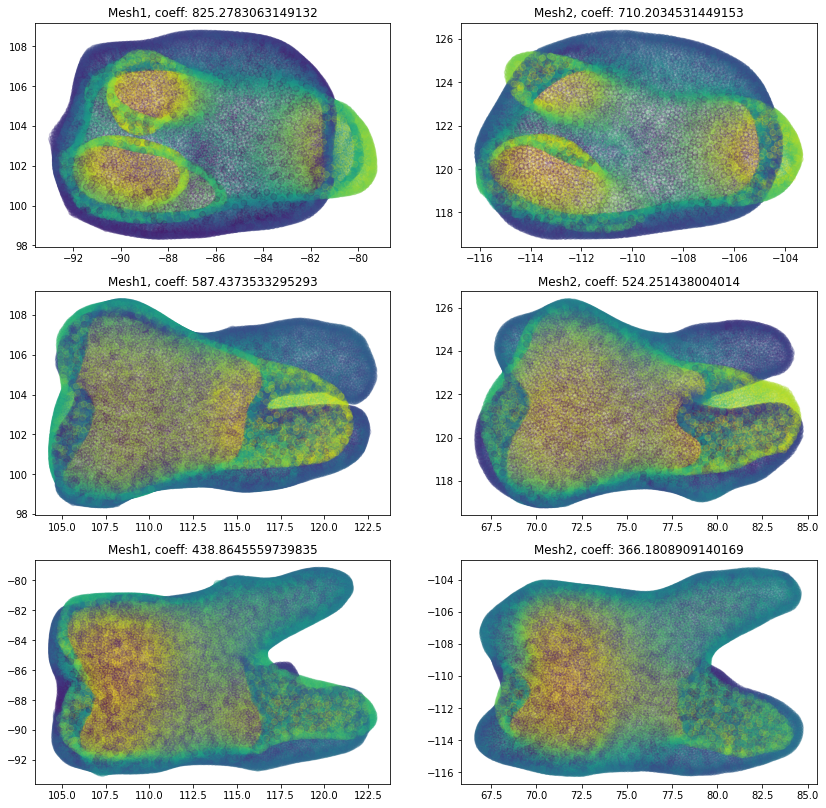

In [128]:
pca = PCA(3)
pca.fit(mesh1.vertices)
pca.components_

p1_0 = mesh1.vertices @ pca.components_[[1,2]].T
d1_0 = mesh1.vertices @ pca.components_[0]
p1_1 = mesh1.vertices @ pca.components_[[0,2]].T
d1_1 = mesh1.vertices @ pca.components_[1]
p1_2 = mesh1.vertices @ pca.components_[[0,1]].T
d1_2 = mesh1.vertices @ pca.components_[2]

pca2 = PCA(3)
pca2.fit(mesh2.vertices)
pca2.components_

p2_0 = mesh2.vertices @ pca2.components_[[1,2]].T
d2_0 = mesh2.vertices @ pca2.components_[0]
p2_1 = mesh2.vertices @ pca2.components_[[0,2]].T
d2_1 = mesh2.vertices @ pca2.components_[1]
p2_2 = mesh2.vertices @ pca2.components_[[0,1]].T
d2_2 = mesh2.vertices @ pca2.components_[2]

f, axarr = plt.subplots(3, 2, figsize = (14,14))
axarr[0,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[0]))
axarr[0,0].scatter(p1_0[:,0],p1_0[:,1], c=d1_0, alpha=0.2)
axarr[1,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[1]))
axarr[1,0].scatter(p1_1[:,0],p1_1[:,1], c=d1_1, alpha=0.2)
axarr[2,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[2]))
axarr[2,0].scatter(p1_2[:,0],p1_2[:,1], c=d1_2, alpha=0.2)

axarr[0,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[0]))
axarr[0,1].scatter(p2_0[:,0],p2_0[:,1], c=d2_0, alpha=0.2)
axarr[1,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[1]))
axarr[1,1].scatter(p2_1[:,0],p2_1[:,1], c=d2_1, alpha=0.2)
axarr[2,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[2]))
axarr[2,1].scatter(p2_2[:,0],p2_2[:,1], c=d2_2, alpha=0.2)

In [129]:
T_pca = pca2.mean_ - pca.mean_ #Translation
norm_axis1 = pca.components_ / np.linalg.norm(pca.components_, axis=1)
norm_axis2 = pca2.components_ / np.linalg.norm(pca2.components_, axis=1)
R_pca = np.einsum("ij,ik->ijk", norm_axis1, norm_axis2).sum(0) #Rotation as in https://math.stackexchange.com/questions/1125203/finding-rotation-axis-and-angle-to-align-two-3d-vector-bases
S_pca = np.sqrt(pca2.singular_values_ / pca.singular_values_) #scale

In [130]:
aligned_mesh1 = pymesh.form_mesh((mesh1.vertices - pca.mean_) @ R_pca * S_pca + pca.mean_ + T_pca, mesh1.faces)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh(aligned_mesh1.vertices, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.49834…

1

# Trying to get automated landmarks

In [131]:
mesh1.add_attribute("vertex_mean_curvature")
mesh1.add_attribute("vertex_gaussian_curvature")
mesh1.add_attribute("vertex_area")
k = mesh1.get_attribute("vertex_mean_curvature")


p = plot(mesh1.vertices, mesh1.faces, c=k>0.5, shading={"wireframe": True})
p = plot(mesh1.vertices, mesh1.faces, c=d1_0, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54518…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54518…

In [132]:
def topk(x,k):
    return x.argsort()[-k:][::-1]

In [133]:
dist = 1.5
idx_concave = np.where(k > 0.5)[0]# topk(k,200)
#idx_convex = topk(-k,100)
#idx = np.concatenate([idx_concave[(np.abs(mesh1.vertices[idx_concave, 2] - mesh1.vertices[:,2].min()) < dist) | (np.abs(mesh1.vertices[idx_convex, 2] - mesh1.vertices[:,2].max()) < dist)],
#                     idx_convex[np.abs(mesh1.vertices[idx_convex, 2] - mesh1.vertices[:,2].max()) < dist]])
proj = mesh1.vertices @ pca.components_[0]
idx = idx_concave[(np.abs(proj[idx_concave] - proj.min()) < dist) | (np.abs(proj[idx_concave] - proj.max()) < dist)]

def filter_number(idx, vertices):
    d = 1.
    tree = KDTree(vertices[idx])
    inside_ball = tree.query_radius(vertices[idx], d)
    number = np.array(list(map(len, inside_ball)))
    return idx[number > 10]

idx = filter_number(idx, mesh1.vertices)

p = plot(mesh1.vertices, mesh1.faces, c=k, shading={"wireframe": True})
p.add_points(mesh1.vertices[idx], c=proj[idx], shading={"point_size": 4})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(129.54518…

1

In [134]:
p1 = np.array([1, 2, 3])
p2 = np.array([4, 6, 9])
p3 = np.array([12, 11, 9])

# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1

# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)

# Using ICL to rigidly match the teeth after a first PCA alignment

In [135]:
R, T = igl.iterative_closest_point(aligned_mesh1.vertices, mesh1.faces, mesh2.vertices, mesh2.faces, num_samples=8000, max_iters=100)

In [136]:
final_aligned_mesh1 = pymesh.form_mesh(aligned_mesh1.vertices @ R + T, mesh1.faces)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh(final_aligned_mesh1.vertices, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.49834…

1

# If you want to rotate along one axis

In [137]:
from scipy.linalg import expm
def Rot(axis, theta):
    return expm(np.cross(np.eye(3), axis/np.linalg.norm(axis)*np.pi*theta/180))

axis = PCA(3).fit(final_aligned_mesh1.vertices).components_[0]
center = PCA(3).fit(final_aligned_mesh1.vertices).mean_
R2 = Rot(axis, 180)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh((final_aligned_mesh1.vertices - center) @ R2 + center, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.49834…

1

I'm pretty sure we should look at SIFt features on 3D meshes:
http://yosi-keller.narod.ru/publications/pdf/mesh_descriptors_two_columns_final.pdf
and the code :
https://github.com/talda/ldsift

This allow to find landmarks so we could do rigid transformation with landmarks + use it after for non-rigid transformation

# Non-rigid deformation using optimization of a cost function

In [138]:
def check_angle(vec1,vec2,threshAngle):
    if (len(vec1) == 0 or len(vec2) == 0):
        return np.ones((vec2.shape[0],1))

    crossProd = np.cross(vec1,vec2,1)
    dotProd = np.sum((vec1*vec2),1)
    angle = np.arctan2((np.sum((crossProd**2),1))**0.5, dotProd)/np.pi*180

    angle = angle%360

    return angle <= threshAngle

In [139]:
def cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, AM=None, NN_M2S=None, dist=None, is_valid_nn=None):
    N = M.num_vertices
    A = A.reshape(3,4,N)
    
    #if AM is None:
    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    #if (dist is None and is_valid_nn is None) or NN_M2S is None:
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    #if is_valid_nn is None:
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)

    E_smooth = 0
    nSmooth = 0
    for i in range(N):
        ring = M.get_vertex_adjacent_vertices(i)
        E_smooth += (np.linalg.norm(A[:,:,i:i+1] - A[:,:,ring])**2).sum()
        nSmooth += len(ring)
    E_smooth *= W_smooth/nSmooth

    if W_data > 0 and np.sum(is_valid_nn) > 0:
        E_data = (is_valid_nn/np.sum(is_valid_nn) * np.linalg.norm(AM.vertices - S.vertices[NN_M2S])**2).sum()
    else:
        E_data = 0.

    E_lm = (np.linalg.norm(np.einsum("ijk,jk->ki",A[:,:,landmarks_M], M.vertices[landmarks_M].T) - S.vertices[landmarks_S])**2).sum()
    if (len(landmarks_M) > 0):
        E_lm *= W_lm/len(landmarks_M)

    E_total = E_data + E_smooth + E_lm

    return E_total

def grad_cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, AM=None, NN_M2S=None, dist=None, is_valid_nn=None):
    N = M.num_vertices
    A = A.reshape(3,4,N)
    
    #if AM is None:
    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    #if (dist is None and is_valid_nn is None) or NN_M2S is None:
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    #if is_valid_nn is None:
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)

    G_data = 0
    if W_data > 0 and np.sum(is_valid_nn) > 0:
        G_data = W_data * is_valid_nn/np.sum(is_valid_nn) * 2 * np.einsum("ki,kj->jik", M.vertices, AM.vertices - S.vertices[NN_M2S])
    
    G_smooth = np.zeros((3,4,N))
    nSmooth = 0
    for i in range(N):
        ring = M.get_vertex_adjacent_vertices(i)
        G_smooth[:,:,i] += 2*(A[:,:,i:i+1] - A[:,:,ring]).sum(2)
        nSmooth += len(ring)
    G_smooth *= W_smooth/nSmooth

    G_lm = np.zeros((3,4,N))
    G_lm[:,:,landmarks_M] = 2 * np.einsum("ki,kj->jik", M.vertices[landmarks_M], np.einsum("ijk,jk->ki",A[:,:,landmarks_M], M.vertices[landmarks_M].T) - S.vertices[landmarks_S])
    if (len(landmarks_M) > 0):
        G_lm *= W_lm/len(landmarks_M)

    G = G_lm + G_smooth + G_data
    G = G.reshape([3*4*N,1])
    return G

In [140]:
W_data = 1
W_smooth = 1e+6
W_lm = 1e-3
dist_min = 0.4
A = np.array([np.concatenate([np.identity(3), np.zeros((3,1))],1) + 0.01*(2*np.random.random()-1) for _ in range(mesh1.num_vertices)]).transpose(1,2,0)

S = pymesh.form_mesh(mesh2.vertices - mesh2.vertices.mean(0), mesh2.faces)
M = pymesh.form_mesh(np.concatenate([final_aligned_mesh1.vertices - mesh2.vertices.mean(0), np.ones((mesh1.num_vertices,1))], 1), mesh1.faces)
M.enable_connectivity()

landmarks_M = []
landmarks_S = []

In [141]:
cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)

3521.7914823222163

In [142]:
grad_cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)

array([[-0.05107083],
       [ 0.04738399],
       [ 0.67421735],
       ...,
       [-0.34949149],
       [-0.21732206],
       [ 1.34752109]])

In [143]:
from scipy.optimize import minimize, fmin_l_bfgs_b

W_data = 1
W_smooth = 1e+6
W_lm = 1e-3
dist_min = 0.4
A = np.array([np.concatenate([np.identity(3), [[0],[0],[0]]],1) + 0.01*(2*np.random.random()-1) for _ in range(mesh1.num_vertices)]).transpose(1,2,0)

fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)

it = 1
maxiter = 400
errPrev = np.inf
err = 1e9
eps_err = 1e-3

while (np.abs(errPrev - err) > eps_err and W_smooth >= W_data*1e3 and it <= maxiter):  
    errPrev = err
    A, err, _ = fmin_l_bfgs_b(cost_fun, A, grad_cost_fun, args=fun_args, maxiter=1)
    
    A = A.reshape(3,4,mesh1.num_vertices)

    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)
    
    dist = np.linalg.norm(AM.vertices - S.vertices[NN_M2S])**2
    distAll = (dist * is_valid_nn).sum()
    
    W_smooth *= 0.75
    W_lm *= 0.75
    fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, AM, NN_M2S, dist, is_valid_nn)
    
    print('{} ERR: {} %_valid_nn: {} Dist: {}'.format(it, err, np.sum(is_valid_nn) / len(is_valid_nn), distAll))
    it += 1

1 ERR: 3042.785246800452 %_valid_nn: 0.7710868565215573 Dist: 49847512.02000524
2 ERR: 2760.5678659500163 %_valid_nn: 0.7747668632124786 Dist: 49896894.1512209
3 ERR: 2697.4672338962177 %_valid_nn: 0.777025049136453 Dist: 49954171.61482966
4 ERR: 2690.943066914734 %_valid_nn: 0.7774850499728181 Dist: 49969556.950705424
5 ERR: 2686.886458469633 %_valid_nn: 0.7771923221678585 Dist: 49921542.77575615
6 ERR: 2686.363505935499 %_valid_nn: 0.7774850499728181 Dist: 49937035.05768999
7 ERR: 2685.5061996309782 %_valid_nn: 0.7775268682306695 Dist: 49927914.70021127
8 ERR: 2683.593125729744 %_valid_nn: 0.7777777777777778 Dist: 49910402.516502306
9 ERR: 2682.7516273900183 %_valid_nn: 0.7777359595199264 Dist: 49892889.7881255
10 ERR: 2680.247880119563 %_valid_nn: 0.7780705055827374 Dist: 49868156.17659066
11 ERR: 2678.9360687008466 %_valid_nn: 0.7784050516455484 Dist: 49865395.490596086
12 ERR: 2675.213215212922 %_valid_nn: 0.7788232342240622 Dist: 49822968.0439516
13 ERR: 2673.0149393058377 %_vali

After the first optimization with decreasing weights for landmarks and smoothness regularization, we continue with fixed weights

In [144]:
it = 1
def callbackF(A, *args):
    global it
    print(it, cost_fun(A, *fun_args))
    it += 1

fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min)
res = minimize(cost_fun, A, args=fun_args, method='L-BFGS-B', jac=grad_cost_fun, callback=callbackF, options={'maxiter':400, 'disp':True})

1 2219.272551477694
2 2125.966349179699
3 1633.9243380375235
4 1615.0230309749936
5 1613.3520420634386
6 1566.1259922745614
7 1392.3957692856895
8 1279.2912845563885
9 1226.31494007939
10 1149.3403282027398
11 1059.3866251905545
12 975.0988667386291
13 898.5554366968926
14 843.1537809007139
15 786.3728699348483
16 711.4551725122008
17 663.1728125837366
18 628.423272972653
19 589.0728528623384
20 550.3801981192418
21 520.0935538483927
22 501.38878828618516
23 489.27223966013963
24 474.7727867155194
25 456.48288127423297
26 444.23708810917805
27 430.0020860904772
28 417.61406693979905
29 406.0490244485032
30 393.8155154266947
31 383.4342471316236
32 376.81760609815683
33 370.5647396988624
34 366.72547258764763
35 360.9614573690936
36 356.2977068652891
37 351.5444261723397
38 346.9026429303436
39 342.88663578450496
40 336.83323755188457
41 329.5691864434657
42 324.0280113393168
43 318.8596197907718
44 315.09748722113414
45 307.761580410604
46 302.2780430196602
47 297.8072028943772
48 293.

In [145]:
comp_A = res.x.reshape(3,4,mesh1.num_vertices)
comp_A[:,:,0]

array([[ 1.04282494e+00, -2.04890357e-02, -1.80951456e-02,
        -6.56226574e-03],
       [-3.24576844e-02,  1.01848544e+00,  1.60127991e-02,
         1.41849858e-03],
       [ 1.47104293e-02, -4.29376649e-05,  1.01014398e+00,
         1.42295675e-03]])

In [146]:
AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",comp_A, M.vertices.T), M.faces)
tree = KDTree(S.vertices, leaf_size=40)
dist, NN_M2S = tree.query(AM.vertices,1)
NN_M2S = NN_M2S.flatten()
dist = dist.flatten()
AMn = igl.per_vertex_normals(AM.vertices, M.faces)
Sn = igl.per_vertex_normals(S.vertices, S.faces)
is_valid_nn = check_angle(AMn, Sn[NN_M2S], 60) & (dist <= dist_min)
print(is_valid_nn.sum()/len(is_valid_nn))
plot(AM.vertices, mesh1.faces, c=is_valid_nn, shading={"wireframe": True})

0.9930163509388199


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.929208…

In [147]:
displacement = ((AM.vertices - M.vertices[:,:3])**2).sum(1)

In [148]:
tree = KDTree(AM.vertices, leaf_size=40)
dist, NN_S2M = tree.query(S.vertices[:,:3],1)
NN_S2M = NN_S2M.flatten()
dist = dist.flatten()
np.linalg.norm(AM.vertices[NN_S2M] - S.vertices, 'fro')

13.019335694051573

In [149]:
# Plot the deformed mesh1
plot(AM.vertices, mesh1.faces, c=displacement, shading={"wireframe": True})
# Plot the mesh2 with distance to NN error as color
plot(mesh2.vertices, mesh2.faces, c=dist, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.929208…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(130.49834…

In [150]:
p = plot(S.vertices[:,:3], mesh2.faces, shading={"wireframe": True})
p.add_mesh(AM.vertices, AM.faces, c=np.array([(0.7,0.7,0.7)]*AM.num_vertices), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.087617…

1

# Row

In [151]:
row1 = pymesh.merge_meshes([pymesh.load_mesh(pjoin("data/ctkDICOM-Database/demo1", "Segmentation_11_{}{}.stl".format(j,i))) for i in range(1,8)for j in [1,2]])
row2 = pymesh.merge_meshes([pymesh.load_mesh(pjoin("data/ctkDICOM-Database/demo1", "Segmentation_11_{}{}.stl".format(j,i))) for i in range(1,8)for j in [3,4]])
row1 = fix_mesh(row1)
row2 = fix_mesh(row2)

Target resolution: 0.3999128021359737 mm
{'num_vertex_merged': 188, 'index_map': array([    0,     1,     2, ..., 73773, 73774, 73775], dtype=int32)}
#v: 23834
#v: 23798
Target resolution: 0.4038898754828206 mm
{'num_vertex_merged': 202, 'index_map': array([    0,     1,     2, ..., 63295, 63296, 63297], dtype=int32)}
#v: 20217
#v: 20182


In [152]:
p = plot(row1.vertices, row1.faces, shading={"wireframe": True})
p.add_mesh(row2.vertices, row2.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(108.35115…

1

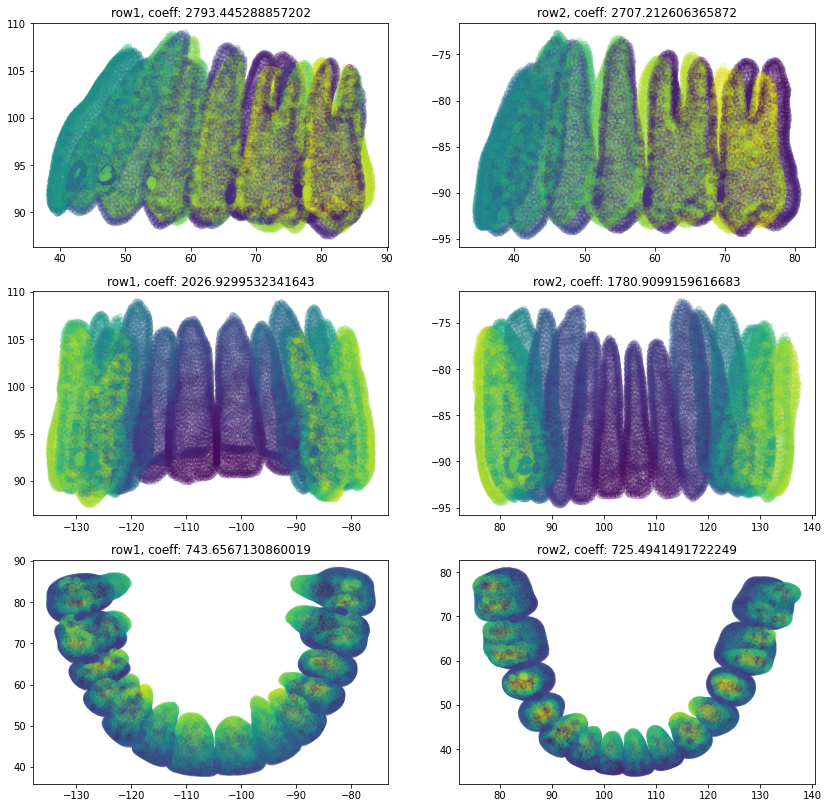

In [153]:
pca = PCA(3)
pca.fit(row1.vertices)
pca.components_

p1_0 = row1.vertices @ pca.components_[[1,2]].T
d1_0 = row1.vertices @ pca.components_[0]
p1_1 = row1.vertices @ pca.components_[[0,2]].T
d1_1 = row1.vertices @ pca.components_[1]
p1_2 = row1.vertices @ pca.components_[[0,1]].T
d1_2 = row1.vertices @ pca.components_[2]

pca2 = PCA(3)
pca2.fit(row2.vertices)
pca2.components_

p2_0 = row2.vertices @ pca2.components_[[1,2]].T
d2_0 = row2.vertices @ pca2.components_[0]
p2_1 = row2.vertices @ pca2.components_[[0,2]].T
d2_1 = row2.vertices @ pca2.components_[1]
p2_2 = row2.vertices @ pca2.components_[[0,1]].T
d2_2 = row2.vertices @ pca2.components_[2]

f, axarr = plt.subplots(3, 2, figsize = (14,14))
axarr[0,0].set_title("row1, coeff: {}".format(pca.singular_values_[0]))
axarr[0,0].scatter(p1_0[:,0],p1_0[:,1], c=d1_0, alpha=0.2)
axarr[1,0].set_title("row1, coeff: {}".format(pca.singular_values_[1]))
axarr[1,0].scatter(p1_1[:,0],p1_1[:,1], c=d1_1, alpha=0.2)
axarr[2,0].set_title("row1, coeff: {}".format(pca.singular_values_[2]))
axarr[2,0].scatter(p1_2[:,0],p1_2[:,1], c=d1_2, alpha=0.2)

axarr[0,1].set_title("row2, coeff: {}".format(pca2.singular_values_[0]))
axarr[0,1].scatter(p2_0[:,0],p2_0[:,1], c=d2_0, alpha=0.2)
axarr[1,1].set_title("row2, coeff: {}".format(pca2.singular_values_[1]))
axarr[1,1].scatter(p2_1[:,0],p2_1[:,1], c=d2_1, alpha=0.2)
axarr[2,1].set_title("row2, coeff: {}".format(pca2.singular_values_[2]))
axarr[2,1].scatter(p2_2[:,0],p2_2[:,1], c=d2_2, alpha=0.2)

In [154]:
T_row_pca = pca2.mean_ - pca.mean_ #Translation
norm_axis1 = pca.components_ / np.linalg.norm(pca.components_, axis=1)
norm_axis2 = pca2.components_ / np.linalg.norm(pca2.components_, axis=1)
R_row_pca = np.einsum("ij,ik->ijk", norm_axis2, norm_axis1).sum(0) #Rotation as in https://math.stackexchange.com/questions/1125203/finding-rotation-axis-and-angle-to-align-two-3d-vector-bases
S_row_pca = np.sqrt(pca2.singular_values_ / pca.singular_values_) #scale

In [155]:
aligned_row1 = pymesh.form_mesh((row1.vertices - pca.mean_) @ R_row_pca * S_row_pca + pca.mean_ + T_row_pca, row1.faces)

p = plot(row2.vertices, row2.faces, shading={"wireframe": True})
p.add_mesh(aligned_row1.vertices, row1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(108.13010…

1